In [145]:
#!pip install nltk

In [392]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer

import pysubs2

import nltk
from sklearn.datasets import load_files
nltk.download('stopwords')
nltk.download('wordnet')
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

import os
import difflib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Основной датафрейм

---

In [300]:
df = pd.read_csv('C:/Users/nikit/Yandex/data/labels.csv')

In [301]:
# функция, которая удаляет слова, которые описывают действия в субтитрах 

def delete_upper(df):
    documents = []
    text = df['Текст']
    
    for string in range(len(text)):
        document = re.sub('\[.+\]', '', text[string])
    
        document = re.sub('\(.+\)', '', document)

        document = re.sub(r"\'d", ' would', document)

        document = re.sub(r"\'n", ' not', document)
        if "can't" in document:
            document = re.sub(r"n\'t", 'n not', document)

        document = re.sub(r"n\'t", ' not', document)

        document = re.sub(r"\'re", ' are', document)

        document = re.sub(r"\'m", ' am', document)

        document = re.sub(r"\'s", ' is', document)

        document = re.sub(r"\'ll", ' will', document)

        document = re.sub(r"\'ve", ' have', document)

        document = re.sub(r"\\n", ' ', document)
        
        documents.append(document)
    
    
    new_documents = []
    for i in range(len(documents)):
        # прохожу по списку предложений и вытаскиваю слова
        words_list = re.findall('[A-Za-z]+', documents[i])
        new_words = ''
        for index in range(len(words_list)):
           # по списку слов просматриваю, слово с верхним регистром или нет, если нет, то добавляю его обратно, 
        #если да, то пропускаю
            word = str(words_list[index])
            if word != word.upper():
                new_words += word + ' '
        new_documents.append(new_words)
    return new_documents

# функция для того, чтобы распаковать субтитры в 1 ячейку

def text_unpacking(df):
    subs_new = pysubs2.load(df['File'])
    string_subtitles = []
    
    for line in subs_new:
        string_subtitles.append(line.plaintext)
        
    return string_subtitles



# функция лемматизации

def lemmatizer_word(df):
    documents_new = []
    stemmer = WordNetLemmatizer()

    for sen in range(0, len(df['Текст_new'])):
        
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(df['Текст_new'][sen]))
        
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)


        # Converting to Lowercase
        document = document.lower()

#         # Lemmatization
        document = document.split()
        
        if document != []:  
        
            document = ' '.join(document)

            documents_new.append(document)
        
    return documents_new


In [302]:
# собираю названия файлов с субтитрами
subs_file_list = os.listdir('C:/Users/nikit/Yandex/data/Subtitles/')
subs_file_list.pop(0)
# делаю список сериалов, чтобы удалить их
list_series = []
for i in df['Movie'].unique():
    if '(series)' in i:
        list_series.append(i)
# удаляю сериалы
df = df.drop(df.query('Movie in @list_series').index)
# заменяю различные знаки. Создал новый столбец, чтобы по нему искать нужный файл, а основной оставался таким каким есть.
# сделано для того, чтобы название Harry Poter (1) осталось и файл был правильно найден, с (1) файл находится неккоректно
df['Movie_new'] = df['Movie'].replace(['\n', " \(1\)", ' 🎙️', ' 😭'], '', regex=True)
df['Movie'] = df['Movie'].replace(['\n', ' 🎙️', ' 😭'], '', regex=True)



# считываю файлы субтитров
df['File'] = df['Movie_new'].apply(lambda x: difflib.get_close_matches(x, subs_file_list, cutoff=0)[0])

In [303]:
df['Текст'] = df.apply(text_unpacking, axis=1)

df = df[['Movie', 'Kinopoisk ', 'Level', 'Subtitles', 'Текст']]

In [304]:
df['Текст_new'] = df.apply(delete_upper, axis=1)


In [305]:
df['Текст_lemmatizer'] = df.apply(lemmatizer_word, axis=1)

df = df.reset_index(drop=True)

In [306]:
# перевожу все в 1 строчку для того, чтобы искать слова по уровням владения языка
def one_string(df):
    text_full = ''
    for text in df['Текст_new']:
        text_full += text + ' '
    
    text_full = text_full.lower()
        
    return text_full

In [307]:
df['Text_string'] = df.apply(one_string, axis=1)

In [308]:
df

,Movie,Kinopoisk,Level,Subtitles,Текст,Текст_new,Текст_lemmatizer,Text_string
0,Forrest Gump,Rus sub,"A2/A2+, B1",Yes,"[Hello., My name's Forrest. Forrest Gump., Do ...","[Hello , My name is Forrest Forrest Gump , Do ...","[hello, my name is forrest forrest gump, do yo...",hello my name is forrest forrest gump do you...
1,Finding Nemo,Everything,A2/A2+,Yes,"[[Music playing], Advertise your product or br...","[, Advertise your product or brand herecontact...",[advertise your product or brand herecontact w...,advertise your product or brand herecontact w...
2,Cast away,"Paid, Rus sub",A2/A2+,Yes,[Created and Encoded by -- Bokutox -- of www...,[Created and Encoded by Bokutox of www com The...,[created and encoded by bokutox of www com the...,created and encoded by bokutox of www com the ...
3,The invisible man (2020),"Paid, Rus lan",A2/A2+,Yes,"[Adrian?, Come on., Zeus, I'm sorry.\nI can't ...","[Adrian , Come on , Zeus am sorry can not take...","[adrian, come on, zeus am sorry can not take y...",adrian come on zeus am sorry can not take yo...
4,Back to the future,Rus sub,A2/A2+,Yes,"[October is inventory time,, so right now, Sta...","[October is inventory time , so right now Stat...","[october is inventory time, so right now statl...",october is inventory time so right now statle...
...,...,...,...,...,...,...,...,...
81,Mary Poppins Returns,NaN,B1,Yes,"[When the early\nmorning hours, Have come and ...","[When the early morning hours , Have come and ...","[when the early morning hours, have come and g...",when the early morning hours have come and go...
82,The fault in our stars,NaN,"A2/A2+, B1",Yes,[I believe we have a choice in this\nworld abo...,[believe we have a choice in this world about ...,[believe we have choice in this world about ho...,believe we have a choice in this world about h...
83,10 Cloverfield Lane,NaN,B1,Yes,"[Fixed & Synced by bozxphd. Enjoy The Flick, (...","[Fixed Synced by bozxphd Enjoy The Flick , , ,...","[fixed synced by bozxphd enjoy the flick, mich...",fixed synced by bozxphd enjoy the flick m...
84,Lion,NaN,"B1, B2",Yes,"[Saroo., Saroo!, Come on, come on!, Get up!, C...","[Saroo , Saroo , Come on come on , Get up , Co...","[saroo, saroo, come on come on, get up, come o...",saroo saroo come on come on get up come on...


---

### Сделать количество времени произношения предложения + количество слов в предложении

Какой план действий? 

Хотелось бы предсказывать не только на субтитрах, но и других фичах, чтобы модель лучше распозновала уровень. Для этого я собираюсь сделать новый фичи, которые будут показывать количество времени произношения предложения, также количество слов в предложении и время произношения одного слова.

Также с помощью этого можно проверить насколько правильно расставлен таргет. 

Есть ещё идея на счет того, чтобы были фичи, которые показывают количество уникальных слов разного уровня в субтитрах, что внесет нереальных вклад в предсказание, потому что это количество слов покажет представление о субтитрах.

In [309]:
count_time_df = df[['Movie', 'Level']].copy()

In [310]:
count_time_df

,Movie,Level
0,Forrest Gump,"A2/A2+, B1"
1,Finding Nemo,A2/A2+
2,Cast away,A2/A2+
3,The invisible man (2020),A2/A2+
4,Back to the future,A2/A2+
...,...,...
81,Mary Poppins Returns,B1
82,The fault in our stars,"A2/A2+, B1"
83,10 Cloverfield Lane,B1
84,Lion,"B1, B2"


In [311]:
count_time_df['Movie_new'] = count_time_df['Movie'].replace(['\n', " \(1\)", ' 🎙️', ' 😭'], '', regex=True)
count_time_df['Movie'] = count_time_df['Movie'].replace(['\n', ' 🎙️', ' 😭'], '', regex=True)

In [312]:
count_time_df['File'] = count_time_df['Movie_new'].apply(lambda x: difflib.get_close_matches(x, subs_file_list, cutoff=0)[0])

In [313]:
count_time_df = count_time_df[['Movie', 'Level', 'File']]

In [36]:
count_time_df

,Movie,Level,File
0,Forrest Gump,"A2/A2+, B1",Forrest_Gump(1994).srt
1,Finding Nemo,A2/A2+,Finding_Nemo(2003).srt
2,Cast away,A2/A2+,Cast_away(2000).srt
3,The invisible man (2020),A2/A2+,The_invisible_man(2020).srt
4,Back to the future,A2/A2+,Back_to_the_future(1985).srt
...,...,...,...
83,The Walking Dead (series)🧟,A2/A2+,The_blind_side(2009).srt
84,The fault in our stars,"A2/A2+, B1",The_fault_in_our_stars(2014).srt
85,10 Cloverfield Lane,B1,10_Cloverfield_lane(2016).srt
86,Lion,"B1, B2",Lion(2016).srt


In [319]:
# с помощью цикла соединяю все фильмы с субтитрами вместе
# создаю первую строчку датафрейма для соединения
df_full = pd.DataFrame({'Movie': 'Forrest Gump', 'Level': 'A2/A2+, B1', 'Текст': 'Hello.'}, index=[0])

for index in count_time_df.index:
    subs = pysubs2.load(count_time_df.loc[index, 'File'])
    start_time = []
    stop_time = []
    text_list = []
    level = count_time_df.loc[index, 'Level']

    for line in subs:
        start_time.append(line.start) # Время начала субтитра
        stop_time.append(line.end) # Время окончания субтитра
        # Время в миллисекундах 

        text_list.append(line.plaintext) # Текст без тегов
        
    df_new = pd.DataFrame({'Начало': start_time, 'Конец': stop_time, 'Текст': text_list, 'Level': level})
    df_new['Movie'] = count_time_df.loc[index, 'Movie']
    df_full = df_full.merge(df_new, how='outer')

In [320]:
df_full

,Movie,Level,Текст,Начало,Конец
0,Forrest Gump,"A2/A2+, B1",Hello.,199349,200599
1,Forrest Gump,"A2/A2+, B1",My name's Forrest. Forrest Gump.,201559,204228
2,Forrest Gump,"A2/A2+, B1",Do you want a chocolate?,209776,211819
3,Forrest Gump,"A2/A2+, B1",I could eat about\na million and a half of these.,214405,217825
4,Forrest Gump,"A2/A2+, B1",My mama always said\nlife was like a box of ch...,218993,224206
...,...,...,...,...,...
130643,House of Gucci,B2,[Tracy] ♪ You'd be mine ♪,9136070,9137905
130644,House of Gucci,B2,[Pavarotti singing in Italian],9139007,9141208
130645,House of Gucci,B2,- [Tracy] ♪ You'd be mine ♪\n- [Pavarotti sing...,9143077,9146814
130646,House of Gucci,B2,[audience cheering],9147515,9149651


In [39]:
# список сокращенных слов, еще не использовал
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and ",
"won't": "would not",
'dis': 'this',
'bak': 'back',
'brng': 'bring'}

In [321]:
# функция для предобработки текста
def preproccesing(df):
    text = df['Текст']
    
    text = re.sub('\[.+\]', '', text)
    
    text = re.sub('\(.+\)', '', text)
    
    text = re.sub(r"\'d", ' would', text)
        
    text = re.sub(r"\'n", ' not', text)
    if "can't" in text:
        text = re.sub(r"n\'t", 'n not', text)
        
    text = re.sub(r"n\'t", ' not', text)

    text = re.sub(r"\'re", ' are', text)

    text = re.sub(r"\'m", ' am', text)

    text = re.sub(r"\'s", ' is', text)

    text = re.sub(r"\'ll", ' will', text)

    text = re.sub(r"\'ve", ' have', text)

    text = re.sub(r"\\n", ' ', text)
    
    words_list = re.findall('[A-Za-z]+', text)
    new_words = ''
    for index in range(len(words_list)):
        word = str(words_list[index])
        if word != word.upper() or word == 'I':
            new_words += word + ' '
    return new_words

In [322]:
df_full['Test'] = df_full.apply(preproccesing, axis=1)

Остаются строки, где текста нет, их я удалю(это строчки с действием и т.д.)

In [323]:
df_full[df_full['Movie'] == '10 Cloverfield Lane']

,Movie,Level,Текст,Начало,Конец,Test
126539,10 Cloverfield Lane,B1,Fixed & Synced by bozxphd. Enjoy The Flick,55279,67279,Fixed Synced by bozxphd Enjoy The Flick
126540,10 Cloverfield Lane,B1,(CLANGING),71280,72838,
126541,10 Cloverfield Lane,B1,(DRAWER CLOSES),76480,77833,
126542,10 Cloverfield Lane,B1,(INAUDIBLE),115800,117597,
126543,10 Cloverfield Lane,B1,(CELL PHONE RINGING),247800,249313,
...,...,...,...,...,...,...
127598,10 Cloverfield Lane,B1,And we 're winning.,5815520,5816839,And we are winning
127599,10 Cloverfield Lane,B1,But if you have any medical trainingor combat ...,5817360,5820636,But if you have any medical trainingor combat ...
127600,10 Cloverfield Lane,B1,there are survivors...,5821440,5823112,there are survivors
127601,10 Cloverfield Lane,B1,(TIRES SQUEALING),5828560,5830357,


In [324]:
index_drop = df_full[df_full['Test'] == ''].index

In [325]:
df_full = df_full.drop(index_drop)

In [326]:
# создаю новые фичи
df_full['Время произношения'] = df_full['Конец'] - df_full['Начало']
df_full['Длина предложения'] = df_full['Test'].apply(lambda x: len(re.findall('[A-Za-z]+', x)))
df_full['Скорость произношения слова'] = df_full['Время произношения'] / df_full['Длина предложения']

In [327]:
df_full

,Movie,Level,Текст,Начало,Конец,Test,Время произношения,Длина предложения,Скорость произношения слова
0,Forrest Gump,"A2/A2+, B1",Hello.,199349,200599,Hello,1250,1,1250.000000
1,Forrest Gump,"A2/A2+, B1",My name's Forrest. Forrest Gump.,201559,204228,My name is Forrest Forrest Gump,2669,6,444.833333
2,Forrest Gump,"A2/A2+, B1",Do you want a chocolate?,209776,211819,Do you want a chocolate,2043,5,408.600000
3,Forrest Gump,"A2/A2+, B1",I could eat about\na million and a half of these.,214405,217825,I could eat about a million and a half of these,3420,11,310.909091
4,Forrest Gump,"A2/A2+, B1",My mama always said\nlife was like a box of ch...,218993,224206,My mama always said life was like a box of cho...,5213,11,473.909091
...,...,...,...,...,...,...,...,...,...
130639,House of Gucci,B2,[Tracy] ♪ Maybe if I told\nyou The right words ♪,9120755,9124792,Maybe if I told you The right words,4037,8,504.625000
130640,House of Gucci,B2,"♪ Ooh, at the right time ♪",9126326,9128796,Ooh at the right time,2470,5,494.000000
130641,House of Gucci,B2,♪ You'd be mine ♪,9129831,9131866,You would be mine,2035,4,508.750000
130643,House of Gucci,B2,[Tracy] ♪ You'd be mine ♪,9136070,9137905,You would be mine,1835,4,458.750000


In [328]:
df_full_concat = df_full.groupby(['Movie', 'Level'], as_index=False)[['Время произношения',
                                                                      'Длина предложения', 
                                                                      'Скорость произношения слова']].mean()

In [329]:
df_full_concat

,Movie,Level,Время произношения,Длина предложения,Скорость произношения слова
0,10 Cloverfield Lane,B1,2074.896797,5.920522,458.784453
1,10 things I hate about you,B1,2433.980640,7.402357,418.785238
2,A knight’s tale,B2,2501.513158,6.213816,508.333175
3,A star is born,B2,2324.552350,6.456026,458.814558
4,Aladdin,A2/A2+,2777.040030,6.181616,626.228691
...,...,...,...,...,...
81,Twilight,A2/A2+,2252.778477,5.536920,563.965515
82,Up,A2/A2+,2502.732240,6.692896,476.196384
83,Venom,B2,2250.889706,6.325000,514.689715
84,Warm bodies,B1,1860.318729,5.381161,491.611602


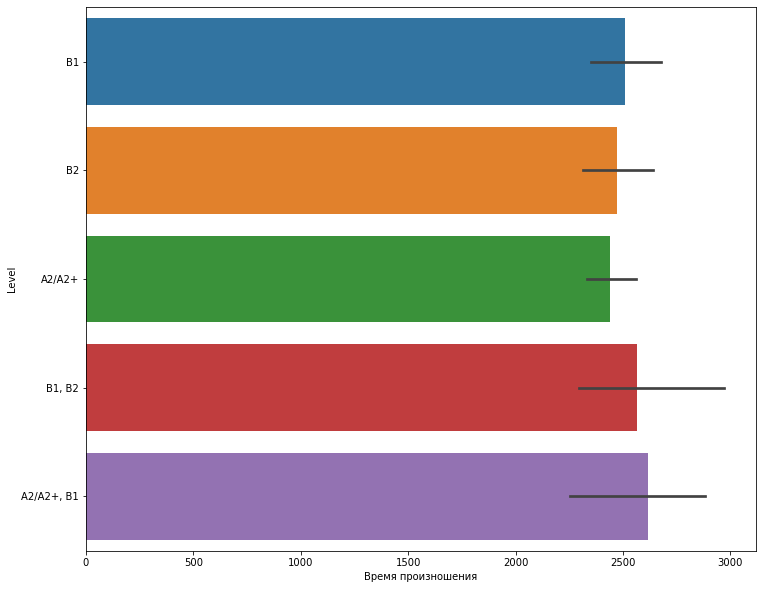

In [330]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Время произношения', y='Level', data=df_full_concat);

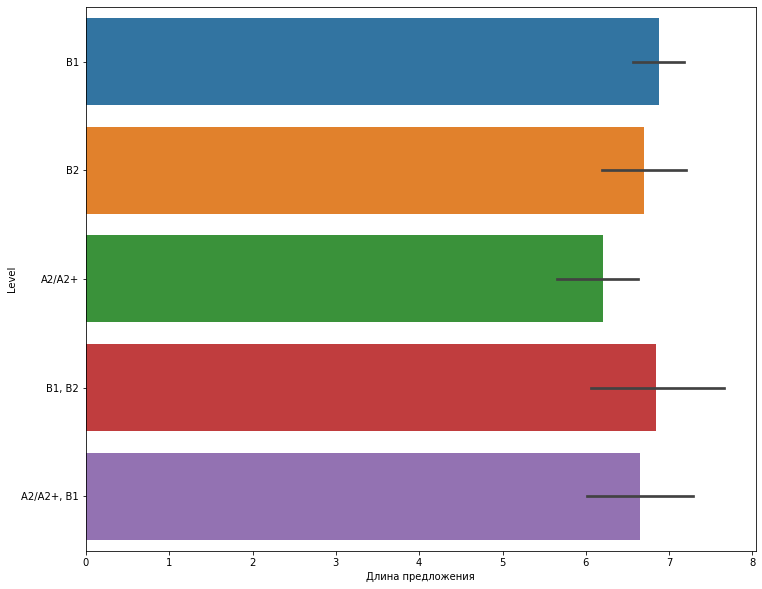

In [331]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Длина предложения', y='Level', data=df_full_concat);

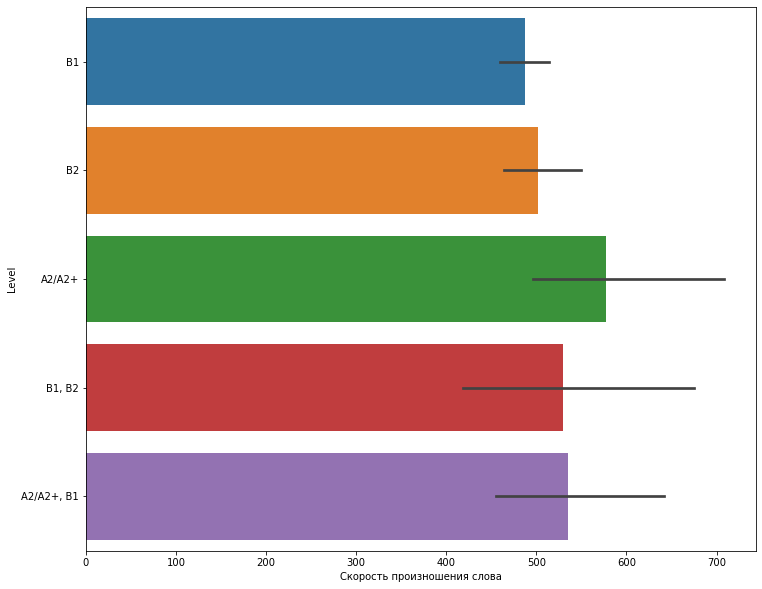

In [332]:
plt.figure(figsize=(12, 10))
sns.barplot(x='Скорость произношения слова', y='Level', data=df_full_concat);

In [298]:
df_full_concat

,Movie,Level,Время произношения,Длина предложения,Скорость произношения слова
0,10 Cloverfield Lane,B1,2074.896797,5.920522,458.784453
1,10 things I hate about you,B1,2433.980640,7.402357,418.785238
2,A knight’s tale,B2,2501.513158,6.213816,508.333175
3,A star is born,B2,2324.552350,6.456026,458.814558
4,Aladdin,A2/A2+,2777.040030,6.181616,626.228691
...,...,...,...,...,...
83,Twilight,A2/A2+,2252.778477,5.536920,563.965515
84,Up,A2/A2+,2502.732240,6.692896,476.196384
85,Venom,B2,2250.889706,6.325000,514.689715
86,Warm bodies,B1,1860.318729,5.381161,491.611602


---

### Слова с level English

---


In [337]:
df_words = pd.read_json('C:/Users/nikit/Documents/GitHub/englishprofile-scraper/englishprofile.json')

In [338]:
df_words

,baseword,guideword,level,partofspeech,topic,url
0,cattle,None,B1,None,animals,/british-english/words/detail/817
1,clothes,None,A1,None,clothes,/british-english/words/detail/972
2,albeit,None,C2,None,None,/british-english/words/detail/157
3,and,ALSO,A1,None,communication,/british-english/words/detail/229
4,and,AFTER,A1,None,communication,/british-english/words/detail/229
...,...,...,...,...,...,...
15691,with your bare hands,IDIOM,C2,phrase,None,/british-english/words/detail/6692
15692,with bated breath,IDIOM,C2,phrase,None,/british-english/words/detail/6692
15693,be lost for words,IDIOM,C2,phrase,None,/british-english/words/detail/6709
15694,not be the end of the world,IDIOM,C2,phrase,None,/british-english/words/detail/6720


In [339]:
df_words = df_words.drop_duplicates(subset='baseword')

In [340]:
test_words = df_words['baseword'].values

In [341]:
test_word_drop = []
for word in test_words:
    if 'etc.' in word:
        test_word_drop.append(word)

In [342]:
def text_clean(text):
    document = re.sub(r"sth", '', text)
    document = re.sub(r"sb's", '', document)
    document = re.sub(r"sb", '', document)
    document = re.sub(r"\(", '', document)
    document = re.sub(r"\)", '', document)
    
    
    if 'etc.' in document:
        document = re.sub('[A-Za-z]+\/[A-Za-z]+[\/[A-Za-z]+]?, etc.', '', document)

        document = re.sub('([A-Za-z]+|\d+)\/([A-Za-z]+|\d+)(\/([A-Za-z]+|\d+))?(,\setc.)?', '', document)

        if '  ' not in document:
            if len(re.findall('[A-Za-z]+', document)) != 1:
                   return document
        else:
            return ''
    else:
        return document

In [343]:
def slash_delete(text_list):
    words_list_new = []

    for phrase in text_list:
        if '/' in phrase:
            change = re.findall('[A-Za-z]+\/[A-Za-z]+[\/[A-Za-z]+]?', phrase)
            for i in range(len(change)):
                slash_word = re.split('/', change[i])
                change_new = change[i]

                for word in range(len(slash_word)):
                    change_word = slash_word[word]
                    new_word = re.sub(change_new, change_word, phrase)
                    words_list_new.append(new_word)
        else:
            words_list_new.append(phrase)
    return words_list_new


In [344]:
df_words['level_test'] = df_words['baseword'].apply(text_clean)

def preproccesing_list(df, level):
    df = df.drop(df[df['level_test'].isna()].index)
    new_list = slash_delete(df[(df['level'] == level)]['level_test'].values)
    
    df_new = pd.DataFrame(new_list)
    df_new.columns = ['Слово']
    df_new = df_new.drop(df_new[df_new['Слово'].duplicated()].index)
    
    return df_new

C:\Users\nikit\AppData\Local\Temp/ipykernel_1360/2814401592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_words['level_test'] = df_words['baseword'].apply(text_clean)


In [345]:
A1 = preproccesing_list(df_words, 'A1')['Слово'].values
A2 = preproccesing_list(df_words, 'A2')['Слово'].values
B1 = preproccesing_list(df_words, 'B1')['Слово'].values
B2 = preproccesing_list(df_words, 'B2')['Слово'].values
C1 = preproccesing_list(df_words, 'C1')['Слово'].values
C2 = preproccesing_list(df_words, 'C2')['Слово'].values

In [346]:
def new_features_words(df, level_list_string):
    count = 0
    for word in level_list_string:
        if word in df['Text_string']:
            count += 1
    return count

In [347]:
df.columns

Index(['Movie', 'Kinopoisk ', 'Level', 'Subtitles', 'Текст', 'Текст_new',
       'Текст_lemmatizer', 'Text_string'],
      dtype='object')

In [348]:
df = df[['Movie', 'Level','Текст_lemmatizer', 'Text_string']]

In [349]:
df['A1'] = df.apply(new_features_words, level_list_string=A1, axis=1)
df['A2'] = df.apply(new_features_words, level_list_string=A2, axis=1)
df['B1'] = df.apply(new_features_words, level_list_string=B1, axis=1)
df['B2'] = df.apply(new_features_words, level_list_string=B2, axis=1)
df['C1'] = df.apply(new_features_words, level_list_string=C1, axis=1)
df['C2'] = df.apply(new_features_words, level_list_string=C2, axis=1)

C:\Users\nikit\AppData\Local\Temp/ipykernel_1360/2546274539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['A1'] = df.apply(new_features_words, level_list_string=A1, axis=1)
C:\Users\nikit\AppData\Local\Temp/ipykernel_1360/2546274539.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['A2'] = df.apply(new_features_words, level_list_string=A2, axis=1)
C:\Users\nikit\AppData\Local\Temp/ipykernel_1360/2546274539.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [350]:
df['Level'].value_counts()

B1            28
A2/A2+        26
B2            19
B1, B2         8
A2/A2+, B1     5
Name: Level, dtype: int64

In [351]:
df[df['Level'] == 'A2/A2+']

,Movie,Level,Текст_lemmatizer,Text_string,A1,A2,B1,B2,C1,C2
1,Finding Nemo,A2/A2+,[advertise your product or brand herecontact w...,advertise your product or brand herecontact w...,229,266,346,255,98,111
2,Cast away,A2/A2+,[created and encoded by bokutox of www com the...,created and encoded by bokutox of www com the ...,214,237,263,180,68,82
3,The invisible man (2020),A2/A2+,"[adrian, come on, zeus am sorry can not take y...",adrian come on zeus am sorry can not take yo...,213,213,269,194,65,75
4,Back to the future,A2/A2+,"[october is inventory time, so right now statl...",october is inventory time so right now statle...,241,306,374,304,102,109
5,Twilight,A2/A2+,[would never given much thought to how would d...,would never given much thought to how would di...,260,297,372,274,93,119
6,Toy story,A2/A2+,"[all right everyone this is stick up, do not a...",all right everyone this is a stick up do not ...,216,262,325,277,90,114
7,The cabin in the woods,A2/A2+,"[it is hormonal, mean do not usually fall back...",it is hormonal mean do not usually fall back ...,214,251,306,261,77,90
8,Up,A2/A2+,[movietown news presents spotlight on adventur...,movietown news presents spotlight on adventure...,223,242,265,209,67,82
9,Dredd,A2/A2+,"[america is an irradiated wasteiand, within it...",america is an irradiated wasteiand within it ...,180,208,270,253,83,100
10,Ready or not,A2/A2+,"[alex this way, come on, hurry, get in and do ...",alex this way come on hurry get in and do n...,212,245,283,221,77,85


In [352]:
df.columns 

Index(['Movie', 'Level', 'Текст_lemmatizer', 'Text_string', 'A1', 'A2', 'B1',
       'B2', 'C1', 'C2'],
      dtype='object')

In [353]:
df = df[['Movie', 'Level', 'Текст_lemmatizer', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']]

In [354]:
df

,Movie,Level,Текст_lemmatizer,A1,A2,B1,B2,C1,C2
0,Forrest Gump,"A2/A2+, B1","[hello, my name is forrest forrest gump, do yo...",270,331,368,279,76,109
1,Finding Nemo,A2/A2+,[advertise your product or brand herecontact w...,229,266,346,255,98,111
2,Cast away,A2/A2+,[created and encoded by bokutox of www com the...,214,237,263,180,68,82
3,The invisible man (2020),A2/A2+,"[adrian, come on, zeus am sorry can not take y...",213,213,269,194,65,75
4,Back to the future,A2/A2+,"[october is inventory time, so right now statl...",241,306,374,304,102,109
...,...,...,...,...,...,...,...,...,...
81,Mary Poppins Returns,B1,"[when the early morning hours, have come and g...",273,365,426,359,105,147
82,The fault in our stars,"A2/A2+, B1",[believe we have choice in this world about ho...,261,324,418,364,120,153
83,10 Cloverfield Lane,B1,"[fixed synced by bozxphd enjoy the flick, mich...",208,221,285,209,63,79
84,Lion,"B1, B2","[saroo, saroo, come on come on, get up, come o...",195,195,185,120,49,53


---

### Baseline

---

In [358]:
from sklearn.feature_extraction.text import CountVectorizer

In [355]:
data = df_full_concat.merge(df)

In [357]:
data

,Movie,Level,Время произношения,Длина предложения,Скорость произношения слова,Текст_lemmatizer,A1,A2,B1,B2,C1,C2
0,10 Cloverfield Lane,B1,2074.896797,5.920522,458.784453,"[fixed synced by bozxphd enjoy the flick, mich...",208,221,285,209,63,79
1,10 things I hate about you,B1,2433.980640,7.402357,418.785238,"[hey, will be right with you, so cameron here ...",240,274,368,309,102,121
2,A knight’s tale,B2,2501.513158,6.213816,508.333175,"[resync xenzai, should we help him, he is due ...",231,241,330,272,100,120
3,A star is born,B2,2324.552350,6.456026,458.814558,"[synced and corrected by mrcjnthn, get to it, ...",246,284,338,235,91,83
4,Aladdin,A2/A2+,2777.040030,6.181616,626.228691,"[oh come from land from faraway place, where t...",224,276,338,290,104,116
...,...,...,...,...,...,...,...,...,...,...,...,...
81,Twilight,A2/A2+,2252.778477,5.536920,563.965515,[would never given much thought to how would d...,260,297,372,274,93,119
82,Up,A2/A2+,2502.732240,6.692896,476.196384,[movietown news presents spotlight on adventur...,223,242,265,209,67,82
83,Venom,B2,2250.889706,6.325000,514.689715,"[life foundation control this is, the specimen...",230,280,347,304,112,101
84,Warm bodies,B1,1860.318729,5.381161,491.611602,"[what am doing with my life, am so pale should...",186,198,227,180,65,64


In [362]:
string_list_all = []
for i in data.index:
    string = ''
    string_list_local = []
    for words in data.loc[i, 'Текст_lemmatizer']:
    
        string += words + ' '
    string_list_local.append(string)
    string_list_all.append(string_list_local)

In [366]:
data_vectorize = pd.DataFrame(string_list_all, columns=['Текст'])

In [368]:
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(data_vectorize['Текст']).toarray()

In [381]:
data_vectorize = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [380]:
data = data[['Level', 'Время произношения', 'Длина предложения',
       'Скорость произношения слова', 'A1', 'A2', 'B1',
       'B2', 'C1', 'C2']]

In [383]:
data_real = data_vectorize.join(data, how='outer')

In [385]:
features_test_join = data_real.drop(['Level'], axis=1)
target_join = data_real['Level']

In [386]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
encoder = OrdinalEncoder()
ordinal = encoder.fit_transform(target_join.values.reshape(-1, 1))
target_new =pd.DataFrame(ordinal)[0].astype(int)

In [387]:
X_train, X_test, y_train, y_test = train_test_split(features_test_join, target_new, test_size=0.33, 
                                                    random_state=42, stratify=target_new)


In [388]:
scaler = MinMaxScaler()
minmax_scaler = scaler.fit(X_train)
X_train = minmax_scaler.transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [390]:
from sklearn.metrics import accuracy_score
model = LogisticRegression(penalty='l2', max_iter=150)

model.fit(X_train, y_train)

prediction = model.predict(X_test)
print(accuracy_score(y_test, prediction))

0.5172413793103449


Пока что хорошо предскывает A2/A2+ и B2

После добавления фичей, уже потихоньку учимся предсказывать B1. Как бы выделить А2 и т.д., могут ли помочь количество слов для каждого уровня? Думаю, что да, нужно попробовать

**Baseline** Прошлый 0.31(предобработанные субтитры), после добавления новых фичей(скорость произношения предложения, длина предложения, скорость произношения слова в предложении) score поднялся до 0.448, неплохо, думаю. После добавления фичей с количеством уникальных слов каждого уровня в субтитре score повысился до 0.51. Я думаю, что таргеты расставлены чутка неккоректно, т.к. количество уникальных слов каждого уровня и графики скорости произношения слова в предложения показывают чуть другую картиру. На счет слов из уровня С1 и С2, возможно, после предобработки был убрат где-то смысл и из-за этого с уровнях ниже, чем С2 встречаются слова С2 больше, чем в С2 :) Но также считаю, что условия равные у каждого субтитра, список со словами каждому субтитру дается одинаковый.

Также есть вариант того, что можно будет предсказывать вероятность того, что он относится к какому-то уровню владением языка.

**Модели:** пока что была использована обычная логистическая регрессия, можно будет использовать бустинг, думаю, что выдаст скор около 60 процентов, после чего можно будет подумать над лучшей предобработкой и расстановке тагерта.